<a href="https://colab.research.google.com/github/riverdogcabin/PSDS4900/blob/main/wu_observation_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import scipy.stats as stats
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, DateFormatter
import seaborn as sns
from pprint import pprint
import json

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.svm import SVR

In [42]:
with open('/content/drive/MyDrive/Capstone/PSDS4900/config.json') as configuration:
  my_station = json.load(configuration).get('WU')["stationid"] #'WU' is the parameters for WeatherUnderground

In [43]:
df = pd.read_csv('/content/drive/MyDrive/Capstone/PSDS4900/wu_data/wu_observations.csv')
df['timestamp'] = pd.to_datetime(df['epoch'], unit='s')
df = df.assign(timestamp_rounded=df.timestamp.dt.round('60min')) #rounded to the hour
print('with dupes',df.shape)
before = df.shape[0]
df.drop_duplicates(inplace=True)
print('without dupes',df.shape)
print('difference: ',before-df.shape[0])

with dupes (66720, 34)
without dupes (66720, 34)
difference:  0


### Clean up the spikes (dupes in each timegroup as outline din the stats notebook)

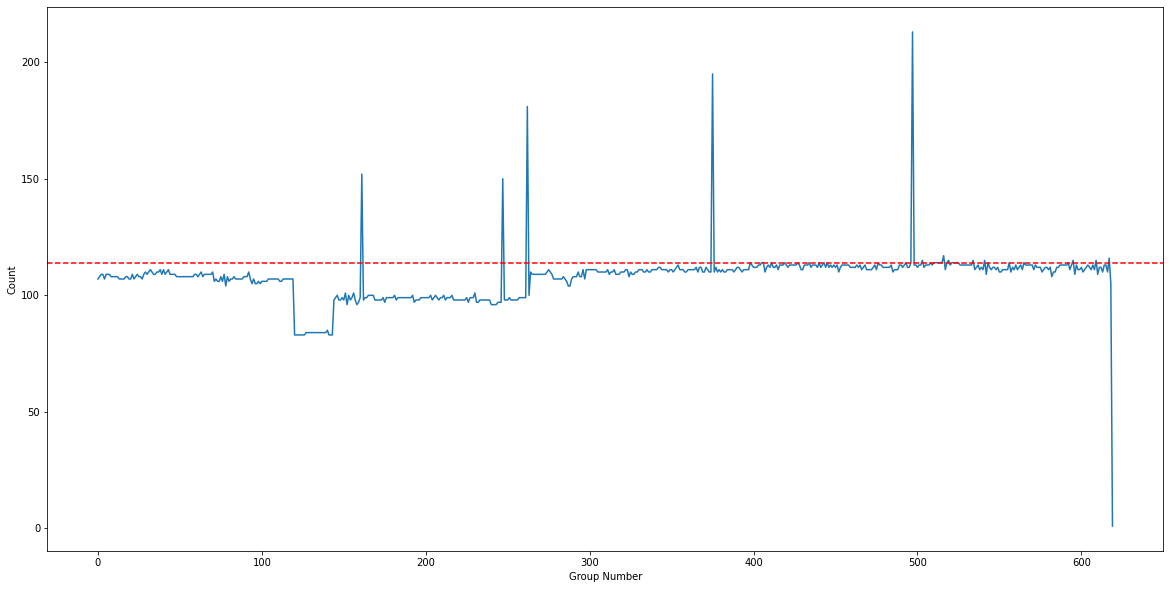

In [44]:
num_stations = len(df.stationID.unique())
counted_df = df.groupby(['timestamp_rounded']).count().reset_index()
ax = counted_df.windspeedAvg.plot(xlabel='Group Number',ylabel='Count',figsize=(20, 10))
ax.axhline(y=num_stations,color='red',linestyle='--')
hour_grouping_std = counted_df.stationID.std()
# problem_hours = list(counted_df[counted_df.stationID > num_stations+hour_grouping_std].timestamp_rounded) #get all groups that are more than one standard deviation off the station count
# indices_to_drop = df[(df.timestamp_rounded.isin(problem_hours)) & (df.timestamp > df.timestamp_rounded)].index
# df.drop(indices_to_drop,inplace=True)

In [45]:
timestamp_target_dict = {}
timestamp_groups_to_remove = []
for tsr in set(df.timestamp_rounded):
  # print(tsr)
  target_timestamp = df[(df.stationID == my_station) & (df.timestamp_rounded == tsr)]
  if(target_timestamp.shape[0] > 0):
    timestamp_target_dict[tsr] = target_timestamp.loc[target_timestamp.timestamp.idxmax()].timestamp
  else:
    timestamp_groups_to_remove.append(tsr) 
# timestamp_target_dict

df['target_timestamp'] = df.timestamp_rounded.map(timestamp_target_dict)
df['offset'] = df.apply(lambda x: abs((x.timestamp-x.target_timestamp).total_seconds()),axis=1)

In [46]:
bad_indices = []
problem_hours = list(counted_df[counted_df.stationID > num_stations+hour_grouping_std].timestamp_rounded)

for hour in problem_hours:
  grouped = df[df.timestamp_rounded == hour].groupby('stationID')
  for group in grouped.groups:
    bad_indices.append(grouped.get_group(group).offset.idxmax())

bad_indices = bad_indices + list(df[df.timestamp_rounded.isin(timestamp_groups_to_remove)].index)
# bad_indices
df.drop(bad_indices,inplace=True)

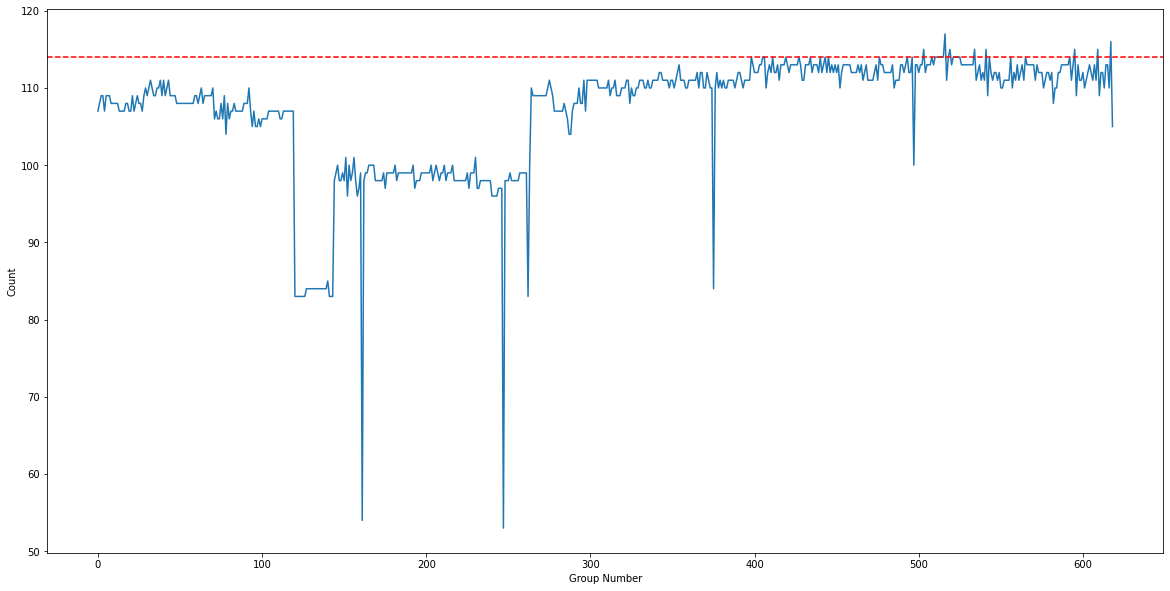

In [47]:
## uncomment the below to check to make sure the spikes are gone
grouped = df.groupby(['timestamp_rounded'])
ax = grouped.count().reset_index().windspeedAvg.plot(xlabel='Group Number',ylabel='Count',figsize=(20, 10))
# ax.axhline(y=55,color='green',linestyle='--')
ax.axhline(y=num_stations,color='red',linestyle='--')

### Build correlation DataFrame and the dict of maximally correlated stations

In [48]:
columns_to_check = [s for s in df.columns if "Avg" in s]
corr_df = pd.DataFrame({'stationID':df.stationID.unique()}) #create the shell of the dataframe to store the correlations
max_correlations = {} #this will hold the maximally correlated stations for each variable
for v in columns_to_check:
  #create a pivot table for each variable
  temp_df = df.pivot_table(index='timestamp_rounded',columns='stationID',values=v).corr()[[my_station]]
  temp_df.columns.name = None #get rid of the column names and then collapse the indices, reindex and rename the columns
  temp_df = temp_df.stack().reset_index().drop(columns='level_1').rename(columns={0:v+'_corr'})
  #get rid of the results for my_station, obvs 
  temp_df = temp_df[temp_df.stationID != my_station]
  #collect the maximally correlated station for the variable
  max_correlations[v] = temp_df.loc[temp_df[v+'_corr'].abs().idxmax()]
  #add all the corrleations for this variable as a column to the big correlation dataframe
  corr_df = corr_df.merge(temp_df,on='stationID')

### Now let's build a simple linear regression model and test it. Found a [ great code snippet to set up k-fold cross validation](https://becominghuman.ai/linear-regression-in-python-with-pandas-scikit-learn-72574a2ec1a5) and adapted it. We'll start by just using the most highly-correlated station to create the model.

In [49]:
def get_top_n_correlated(df,corr_df,num_stations=5,variable='windspeedAvg',my_station='KCOPARKE414'):
  target_stations = corr_df.sort_values(variable+'_corr',ascending=False).stationID.to_list()[:num_stations]
  target_stations.append(my_station)
  df_filtered = df[df.stationID.isin(target_stations)]
  df_reshaped = df_filtered.pivot_table(index='timestamp_rounded',columns='stationID',values=variable)
  before = df_reshaped.shape[0]
  df_reshaped.dropna(inplace=True)
  return df_reshaped, before-df_reshaped.shape[0]

In [50]:
# target_stations = [my_station, max_correlations['windspeedAvg'].stationID]
# df_filtered = df[df.stationID.isin(target_stations)]
# df_reshaped = df_filtered.pivot_table(index='timestamp_rounded',columns='stationID',values='windspeedAvg')
# before = df_reshaped.shape[0]
# df_reshaped.dropna(inplace=True)
# print("dropping N/A rows reduced from {} to {}. Loss of {} rows".format(before,df_reshaped.shape[0],before - df_reshaped.shape[0]))
# pd.options.display.max_rows = 300 #so we can show the whole dataframe
# df_reshaped

In [51]:
df_reshaped, num_dropped = get_top_n_correlated(df,corr_df,num_stations=1)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target

model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
print(scores)

[0.7847812735090341, 0.7050827153372481, 0.5301863450294073]


### Those scores aren't bad, but they aren't great. Let's see if adding more stations improves things. We'll take the top five most correlated stations.

In [52]:
df_reshaped, num_dropped = get_top_n_correlated(df,corr_df,num_stations=10)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target

model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
print(scores)

[0.8543077573311613, 0.8650738728317977, 0.7347436933123741]


### Those got better by adding four more highly-correlated stations. Let's see what happens when we add all the stations.

In [53]:
df_reshaped, num_dropped = get_top_n_correlated(df,corr_df,num_stations=-1)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target

model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
print(scores)

[0.798192058721799, -0.04361535660613236, 0.8395812869856076]


### That did *not* improve things. I think that we had to drop too many rows because of missing values. Even though the hourly grouping was the _best_ way to align the data, it still means we lose lots of rows because of missing values. 

In [54]:
df.windspeedAvg.describe()

count    66202.000000
mean         4.089425
std          4.764398
min          0.000000
25%          0.500000
50%          2.700000
75%          5.900000
max         58.900000
Name: windspeedAvg, dtype: float64

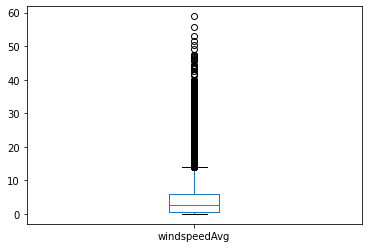

In [55]:
# backing up, taking another look at the distribution of windspeedAvg
df.windspeedAvg.plot(kind='box')

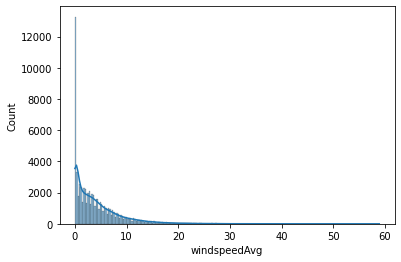

In [56]:
sns.histplot(data=df, x="windspeedAvg", kde=True)

In [57]:
model_dict = {'svr_rbf': SVR(kernel='rbf', C=1e3, gamma=0.1), 
              'svr_lin': SVR(kernel='linear', C=1e3), 
              'svr_poly': SVR(kernel='poly', C=1e3, degree=2)}
# y_rbf = svr_rbf.fit(X, y).predict(X)
# y_lin = svr_lin.fit(X, y).predict(X)
# y_poly = svr_poly.fit(X, y).predict(X)

In [58]:
df_reshaped, num_dropped = get_top_n_correlated(df,corr_df,num_stations=5)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target


for k, model in model_dict.items() :
  # model = svr_poly
  scores = []
  kfold = KFold(n_splits=3, shuffle=True, random_state=42)

  for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train,:][my_station].ravel())
    score = model.score(X.iloc[test,:], y.iloc[test,:])
    scores.append(score)
  print(k)
  print(scores)

svr_rbf
[0.3439117695423938, 0.3790368666906039, 0.5022552286510263]
svr_lin
[0.8636365129519563, 0.8503024012900297, 0.7127373688146212]
svr_poly
[0.8635646340923988, 0.8266993073382214, 0.7896984894039598]
